In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
import sys
sys.path.append('./Modules')
import monostatic_reconstruct as mr

mm = 1E-3
C = scipy.constants.c

### Load data & antenna coordinates

In [2]:
d_antennas = .035        # distance between tx/rx antennas

mat = scipy.io.loadmat(r'..\..\Data\wall1_with_drywall_2022-11-13.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
measurements = np.flip(mat['measurements'], axis=(0,1))
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\Data\background_2022-11-11.mat')
bg = np.flip(mat['measurements'], axis=(0,1))

### subtract background from measurements
measurements = measurements - bg

NOTES:
second scan of wall1 with drywall.


### Remove probe phase

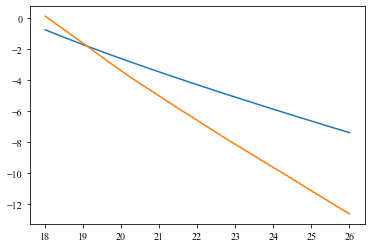

In [3]:
#### load experimentally measured horn phase
mat = scipy.io.loadmat('../../Data/Horn_Calibration_221109/horn_phase.mat')
f_exp = mat['f'][0,:]
phase_error_exp = mat['horn_phase'][0,:]

lam = C/f
k = 2*np.pi/lam

L_horn = .0298
a_horn = 10.668*mm      # WR42
b_horn = 4.318*mm
beta_g = np.sqrt(k**2 - (np.pi/a_horn)**2)
phase_error = np.exp(-1j*2*beta_g*L_horn)    # 2 for transmit and receive path

# measurements = measurements / phase_error[None,None,:]                    # numerically focused horn data
measurements = measurements / np.exp(1j*2*phase_error_exp)[None,None,:]     # experimental horn data

plt.figure()
plt.plot(f*1E-9, np.unwrap(np.angle(phase_error))/2)
plt.plot(f*1E-9, phase_error_exp)
plt.show()

### Reconstruct

##### *Tiled aperture reconstructions*

In [4]:
recon = mr.MonostaticReconstruction(f, Xa, Ya, z_offset)
aperture_center_x = np.linspace(-0.25, 0.25, 10)
aperture_center_y = np.linspace(-0.25, 0.25, 10)
aperture_center_X, aperture_center_Y = np.meshgrid(aperture_center_x, aperture_center_y, indexing='xy')
for i in range(aperture_center_X.shape[0]):
    if i%2 == 1:
        aperture_center_X[i,:] = np.flip(aperture_center_X[i,:])

images = []
for i in range(aperture_center_X.shape[0]):
    for j in range(aperture_center_X.shape[1]):
        recon.setup((.3, .3, .01), (5*mm, 5*mm, 5*mm), Lxa=0.3, Lya=0.3, fc=24.125E9, bw=0.25E9, delta_f_indx=1, aperture_center=(aperture_center_X[i,j], aperture_center_Y[i,j]), scene_offsets=(0,0,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=60, filter_x_offset=0, filter_y_offset=-55, quiet=True)
        recon.reconstruct(measurements)
        images.append(np.transpose(np.mean(np.abs(recon.image)**2, 2), (1,0)))

##### *Large aperture reconstructions*

In [5]:
recon.setup((.8, .8, .01), (5*mm, 5*mm, 5*mm), Lxa=0.8, Lya=0.8, fc=24.125E9, bw=0.25E9, delta_f_indx=1, aperture_center=(0,0), scene_offsets=(0,0,z_offset+0.02), method='RMA-NUFFT', lp_filter=True, filter_radius=60, filter_x_offset=0, filter_y_offset=-55, quiet=True)
recon.reconstruct(measurements)

big_image = np.transpose(np.mean(np.abs(recon.image)**2, 2), (1,0))
big_image = big_image/np.amax(big_image)

### Make animation

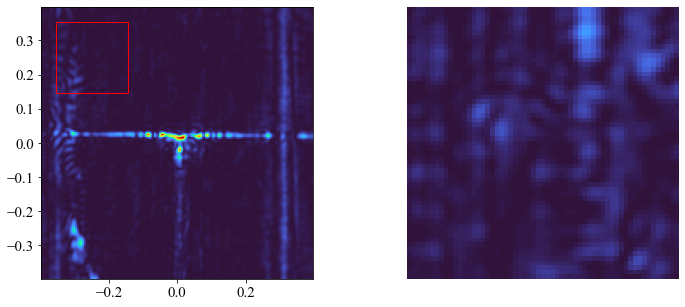

In [7]:
from matplotlib.animation import FuncAnimation, PillowWriter

def set_font(fontsize=25, font="Times New Roman"):
      rc = {"font.size" : fontsize,
      "font.family" : font,
      "mathtext.fontset" : "stix"}
      plt.rcParams.update(rc)
set_font(fontsize=15)

L = 0.21
box_vertices = np.array([[-L/2, -L/2], [-L/2, L/2], [L/2, L/2], [L/2, -L/2]])

# make GIF
# initialize plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(big_image, origin='lower', cmap='turbo', extent=(recon.xa.min(), recon.xa.max(), recon.ya.min(), recon.ya.max()))
ax1.fill(box_vertices[:,0]+aperture_center_X[0,0], box_vertices[:,1]+aperture_center_Y[0,0], facecolor='none', edgecolor='red')
im = ax2.imshow(images[0]/np.amax(np.array(images)), origin='lower', cmap='turbo')
im.set_clim(0.0, 1)
ax2.axis('off')

indx_1, indx_2 = np.meshgrid(np.arange(aperture_center_X.shape[0]), np.arange(aperture_center_X.shape[1]), indexing='ij')
indx_1 = indx_1.flatten()
indx_2 = indx_2.flatten()

def update(i):
    ax1.clear()
    ax1.imshow(big_image, origin='lower', cmap='turbo', extent=(recon.xa.min(), recon.xa.max(), recon.ya.min(), recon.ya.max()))
    ax1.fill(box_vertices[:,0]+aperture_center_X[indx_1[i],indx_2[i]], box_vertices[:,1]+aperture_center_Y[indx_1[i],indx_2[i]], facecolor='none', edgecolor='red')
    ax2.clear()
    im = ax2.imshow(images[i]/np.amax(np.array(images)), origin='lower', cmap='turbo')
    im.set_clim(0.0, 1)
    ax2.axis('off')

ani = FuncAnimation(fig, update, len(images))  

writer = PillowWriter(fps=10)  
ani.save(r'C:\Users\User\Documents\Metacept\Projects\TWI\Experiment\Monostatic Experiments - Shared\Data\Images\twi_tiled.gif', writer=writer)